In [1]:
import fileprocessing
from importlib import reload
import eigendecomp
import preprocessing
import bioframe
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy import optimize


In [2]:
cool_dir = '/media/lchumpitaz/New Volume/work/programas/Data/Hi-C'

In [3]:
cools = fileprocessing.get_files(cool_dir)

In [4]:
df = fileprocessing.get_df(cools, resolution = 100000)

In [5]:
df

cell_line assembly                                               path  \
0   GM12878     hg19  /media/lchumpitaz/New Volume/work/programas/Da...   
1      HMEC     hg19  /media/lchumpitaz/New Volume/work/programas/Da...   
2     HUVEC     hg19  /media/lchumpitaz/New Volume/work/programas/Da...   
3     IMR90     hg19  /media/lchumpitaz/New Volume/work/programas/Da...   
4      K562     hg19  /media/lchumpitaz/New Volume/work/programas/Da...   
5      KBM7     hg19  /media/lchumpitaz/New Volume/work/programas/Da...   
6      NHEK     hg19  /media/lchumpitaz/New Volume/work/programas/Da...   

                                              cooler  
0  <Cooler "GM12878_inSitu_MboI.hg19.mapq_30.1000...  
1  <Cooler "HMEC_inSitu_MboI.hg19.mapq_30.1000.mc...  
2  <Cooler "HUVEC_inSitu_MboI.hg19.mapq_30.1000.m...  
3  <Cooler "IMR90_inSitu_MboI.hg19.mapq_30.1000.m...  
4  <Cooler "K562_inSitu_MboI.hg19.mapq_30.1000.mc...  
5  <Cooler "KBM7_inSitu_MboI.hg19.mapq_30.1000.mc...  
6  <Cooler "NHEK_inSitu_MboI.hg19.mapq_30.1000.mc...

## Get gene coverage

In [6]:
genecov_dict = fileprocessing.get_genecov(df)

In [200]:
bins = df['cooler'].iloc[0].bins()[:]

In [201]:
bins['gene_count'] = genecov_dict['hg19']

## Select a chromosome and get the matrix

In [202]:
ch = 'chr11'

In [203]:
mat = df['cooler'].iloc[0].matrix(balance = False).fetch(ch)
mat

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,  8007,  8857, ...,    25,    36,     0],
       [    0,  8857, 78617, ...,    59,    62,     0],
       ...,
       [    0,    25,    59, ..., 29127,  6497,     0],
       [    0,    36,    62, ...,  6497, 17079,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int32)

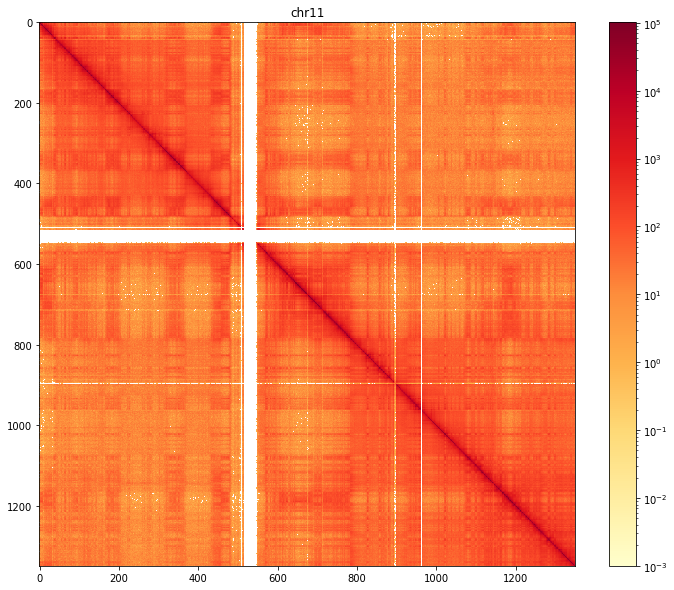

In [204]:
fig = plt.figure(1, figsize=(12, 10)) 
start, end = 0, -1
plt.title(ch)
plt.imshow(mat[start:end,start:end], aspect='auto',cmap='YlOrRd'
              ,interpolation='None',norm= colors.LogNorm(vmin=10**-3, vmax=np.nanmax(mat[start:end,start:end])))
plt.colorbar();

## We see white strands, usually unmappable genome

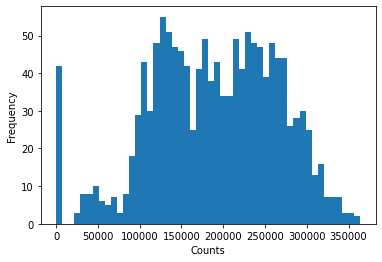

In [205]:
plt.hist(mat.sum(axis =1)[:], 50);
plt.xlabel('Counts')
plt.ylabel('Frequency');

## We get rid of them by building a mask

In [206]:
mask, mask2D = preprocessing.create_mask(mat, start = 1, end = 99)

In [207]:
mat[~mask2D] = 0

## There is still variance in the sum of counts per loci, get take care of that with iterative correction

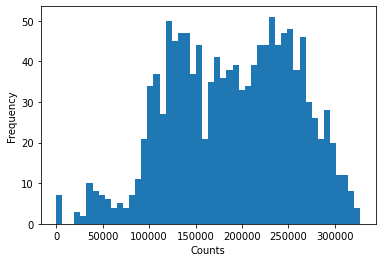

In [208]:
plt.hist(mat[mask].sum(axis =1)[:], 50);
plt.xlabel('Counts')
plt.ylabel('Frequency');

In [209]:
W, B, res = preprocessing.correction(mat, maxiter = 10000)

## Now there is little variance across all loci

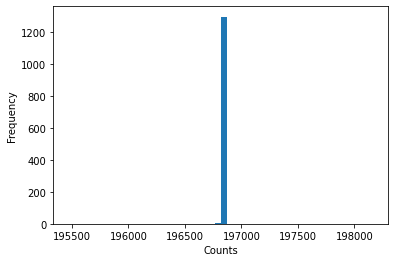

In [210]:
plt.hist(W.sum(axis =1)[mask], 50);
plt.xlabel('Counts')
plt.ylabel('Frequency');

In [211]:
S = np.sum(W, axis =1, keepdims =True)

In [212]:
print('Standard deviation', np.std(S[mask]))
print('Mean', np.mean(S[mask]))
print('Most values are around the same value, having a low standard deviation')

Standard deviation 52.778794615000216
Mean 196818.3509996623
Most values are around the same value, having a low standard deviation


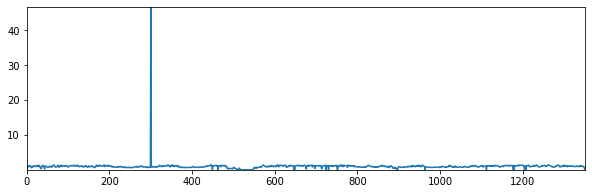

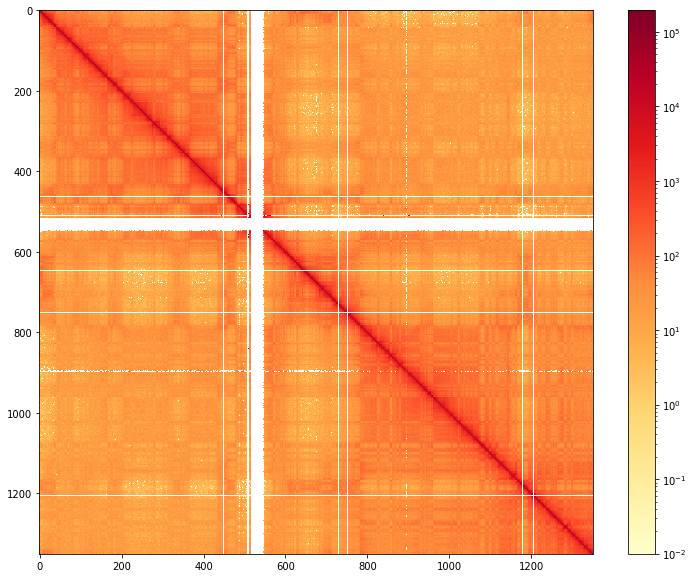

In [213]:
%matplotlib inline
plt.figure(1, figsize = (10, 3))
plt.plot(B)
plt.margins(0)
fig = plt.figure(2, figsize=(12.4, 10)) 
plt.imshow(W, aspect='auto',cmap='YlOrRd'
              ,interpolation='none',norm= colors.LogNorm(vmin=10**-2, vmax=np.nanmax(W)))
plt.colorbar();


## Correction takes care of noise

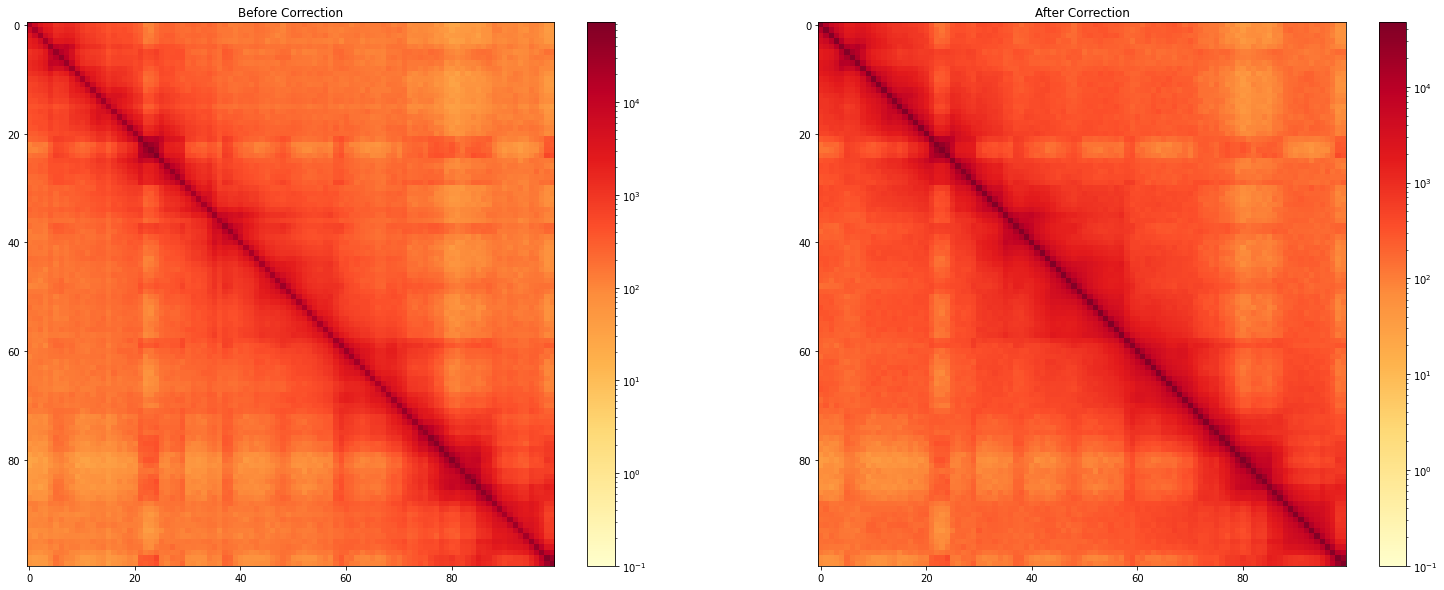

In [214]:
plt.figure(figsize= (26, 10))
plt.subplot(1, 2, 1)
start, end = 1000, 1100
plt.title('Before Correction')
plt.imshow(mat[start:end,start:end] , aspect='auto',cmap='YlOrRd'
              ,interpolation='None',norm= colors.LogNorm(vmin=10**-1, vmax=np.nanmax(mat[start:end,start:end])))
plt.colorbar();
plt.subplot(1, 2, 2)
plt.title('After Correction')
plt.imshow(W[start:end,start:end] , aspect='auto',cmap='YlOrRd'
              ,interpolation='None',norm= colors.LogNorm(vmin=10**-1, vmax=np.nanmax(W[start:end,start:end])));
plt.colorbar();

## We proceed to build an average contact function

In [215]:
P = preprocessing.acd(W)

In [216]:
def test_func(x, a, b):
    return (a*(x**b))

In [217]:
offset = int(len(P)*0.05)
last = int(len(P)*0.1)
x = np.linspace(offset+1, len(W)-last, len(W)-offset-last)
params1, params_covariance = optimize.curve_fit(test_func, x, P[offset:len(W)-last])
p1 = test_func(x, *params1)
params1

array([ 2.90115584e+03, -7.53446943e-01])

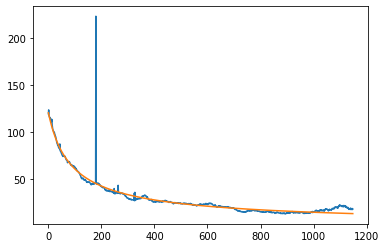

In [218]:
plt.plot(P[offset:len(W)-last])
plt.plot(p1[:])

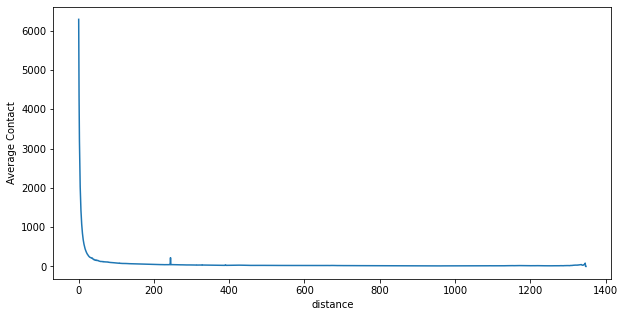

In [219]:
plt.figure(figsize = (10, 5))
plt.plot(P[2:])
plt.xlabel('distance')
plt.ylabel('Average Contact');

## Then we build a matrix based on this function

In [220]:
O = preprocessing.expected(W)

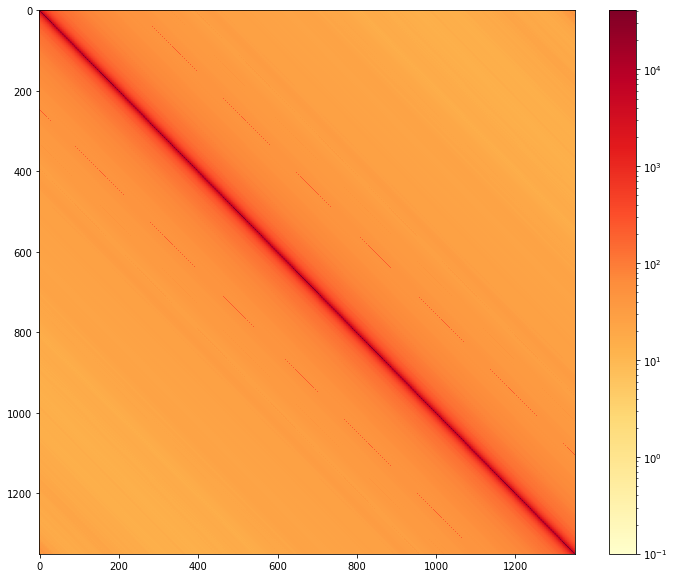

In [221]:
plt.figure(2, figsize = (12, 10))
plt.imshow(O
                ,aspect='auto',cmap='YlOrRd'
              ,interpolation='None',norm= colors.LogNorm(vmin=10**-1, vmax=np.nanmax(O)))
plt.colorbar();

## Apply eigendecomposition to check for potential patterns

In [222]:
S, U= eigendecomp.get_eig(O, n=16)

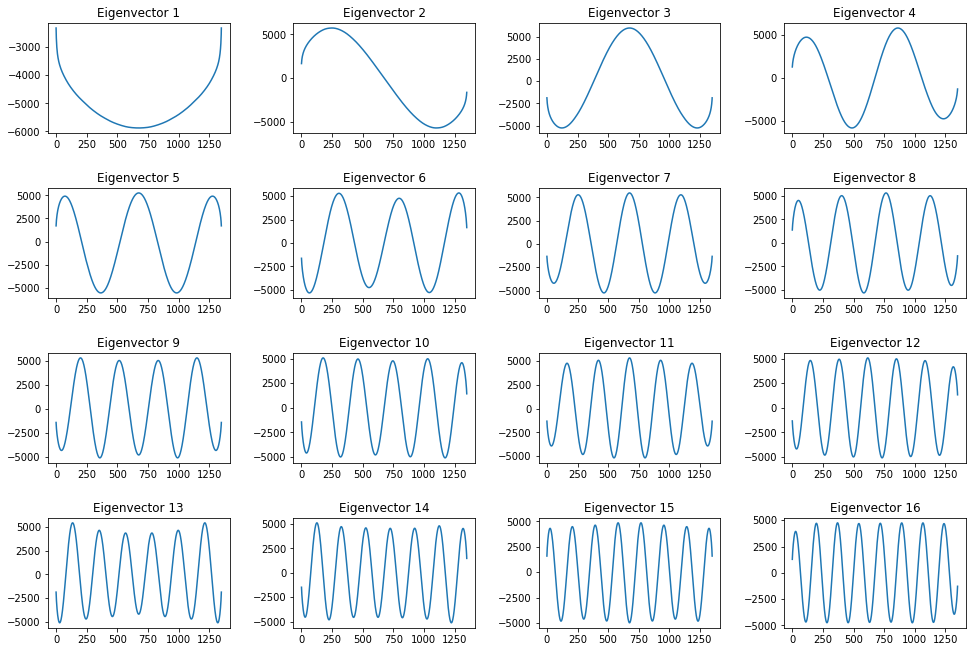

In [223]:
plt.figure(figsize= (15, 10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title('Eigenvector '+ str(i+1))
    plt.plot(S[i]*U[:, i]);
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

In [224]:
outers = eigendecomp.get_outer(O, n = 16)

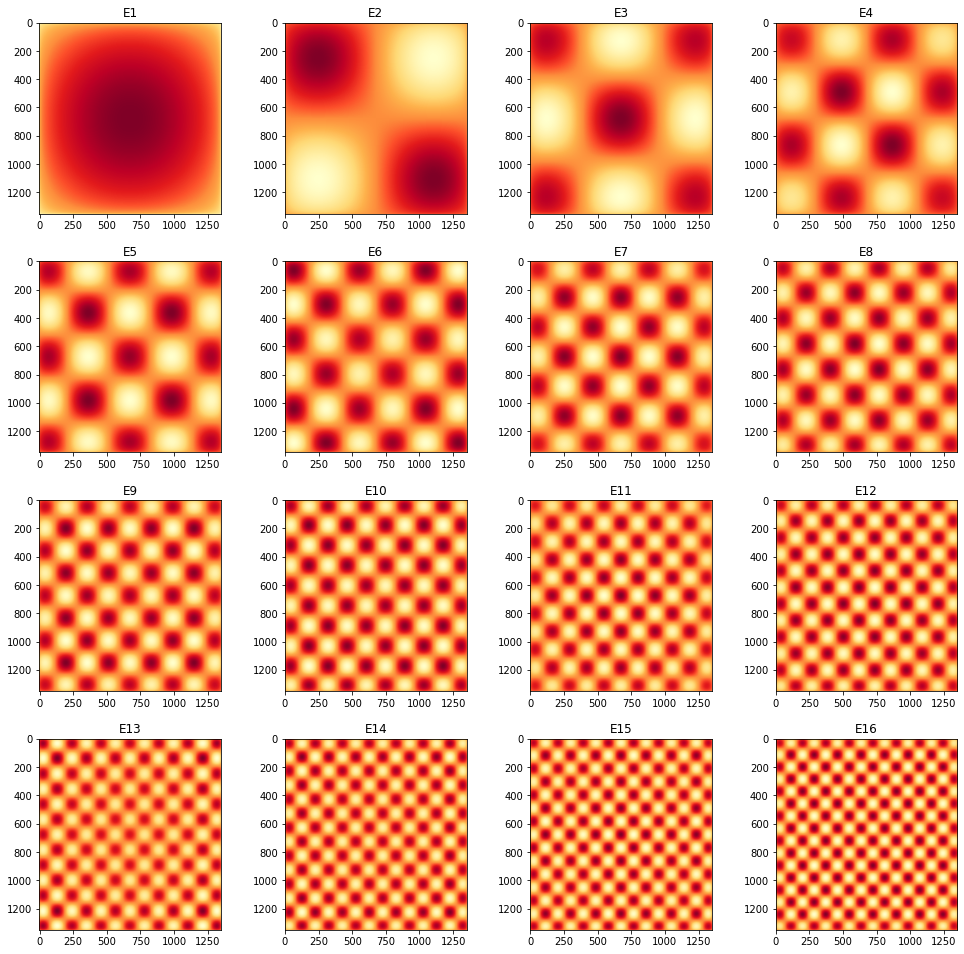

In [225]:
plt.figure(figsize= (15, 15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title('E'+ str(i+1))
    plt.imshow(outers[i],aspect='auto',cmap='YlOrRd');
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

## Get observed/expected

In [226]:
enrichment = preprocessing.enrichment(W, O)

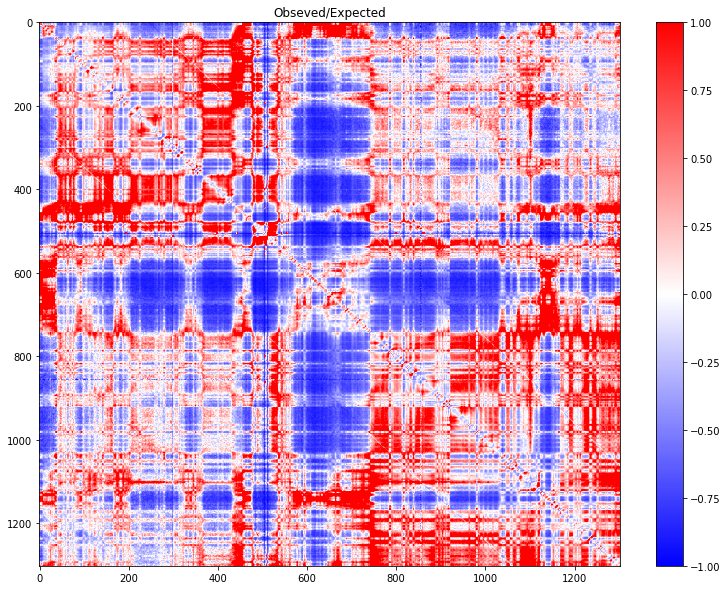

In [227]:
plt.figure(figsize = (13, 10))

plt.title('Obseved/Expected')
plt.imshow(enrichment -1,aspect='auto',cmap='bwr'
          ,interpolation='bilinear', vmin = -1, vmax = 1)
plt.colorbar();
    
plt.show()

In [228]:
S, U= eigendecomp.get_eig(enrichment -1, n=10)

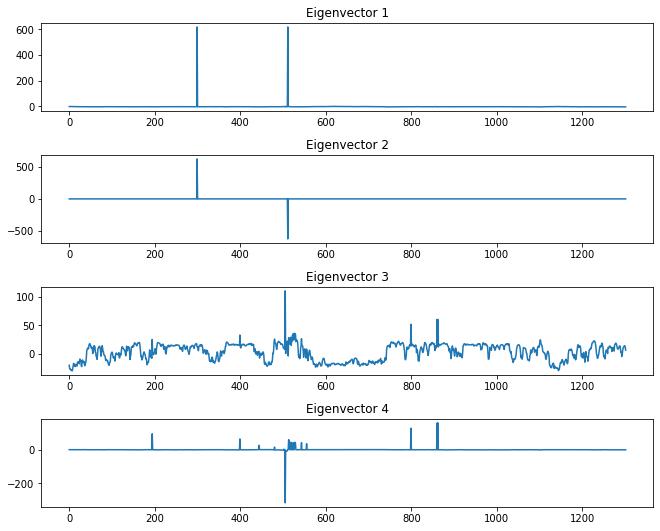

In [229]:
plt.figure(figsize= (10, 8))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.title('Eigenvector '+ str(i+1))
    plt.plot(S[i]*U[:, i]);
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.3)
plt.show()

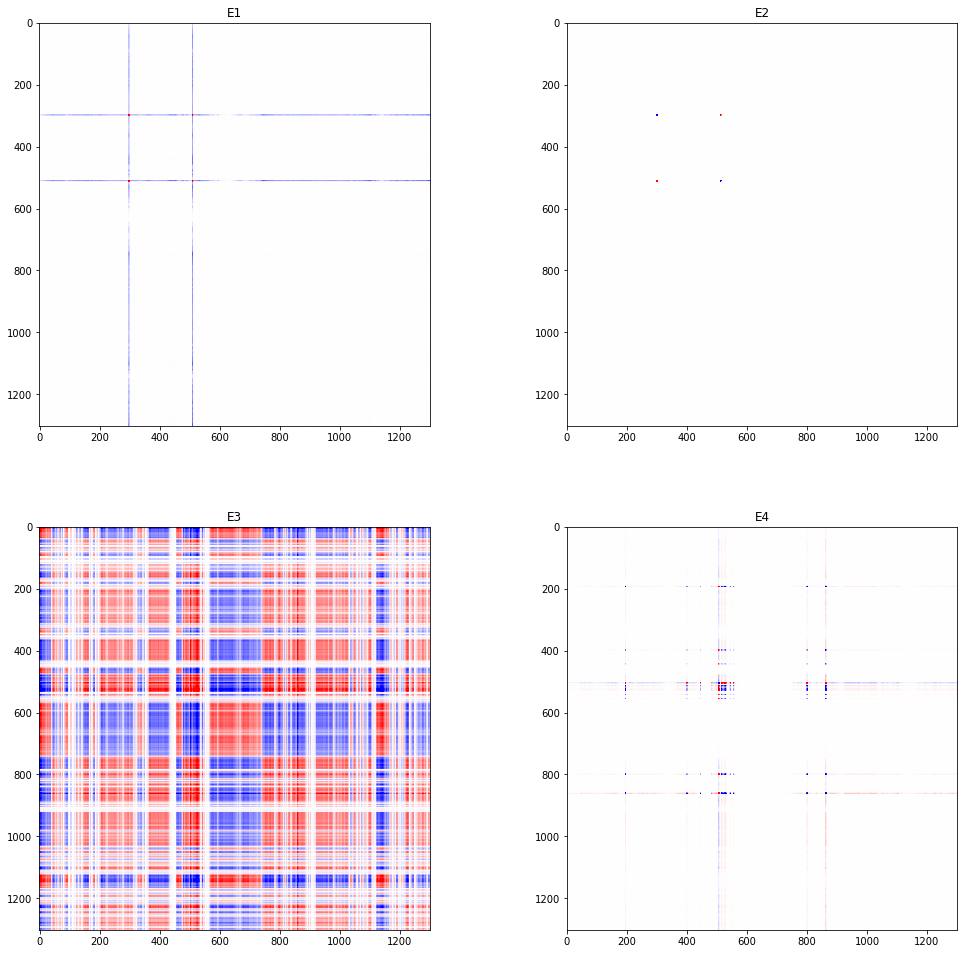

In [149]:
outers = eigendecomp.get_outer(enrichment -1, n = 10)
plt.figure(figsize= (15, 15))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title('E'+ str(i+1))
    plt.imshow(outers[i],aspect='auto',cmap='bwr'
              ,vmin = -1, vmax = 1);
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

## We did not get a good eigendecomposition, lets try clipping values

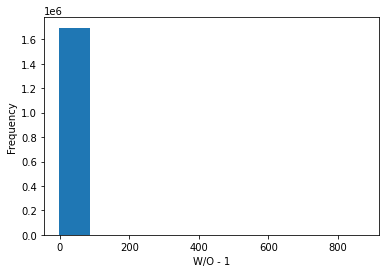

In [190]:
plt.hist(enrichment.reshape(-1,1) -1, bins = 10);
plt.xlabel('W/O - 1');
plt.ylabel('Frequency');

In [151]:
sub = eigendecomp.apply_op(enrichment, operation = 'clip')

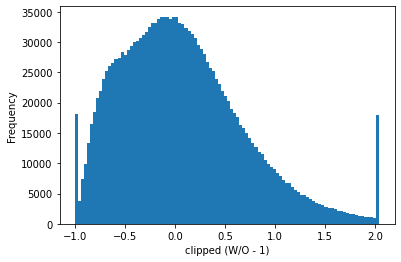

In [191]:
plt.hist(sub.reshape(-1,1), bins = 100);
plt.xlabel('clipped (W/O - 1)');
plt.ylabel('Frequency');

In [192]:
S, U= eigendecomp.get_eig(sub, n=10)

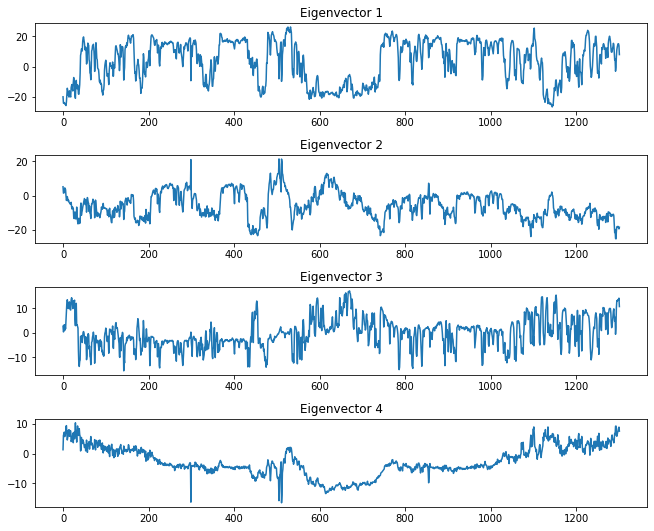

In [196]:
plt.figure(figsize= (10, 8))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.title('Eigenvector '+ str(i+1))
    plt.plot(S[i]*U[:, i]);
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.3)
plt.show()

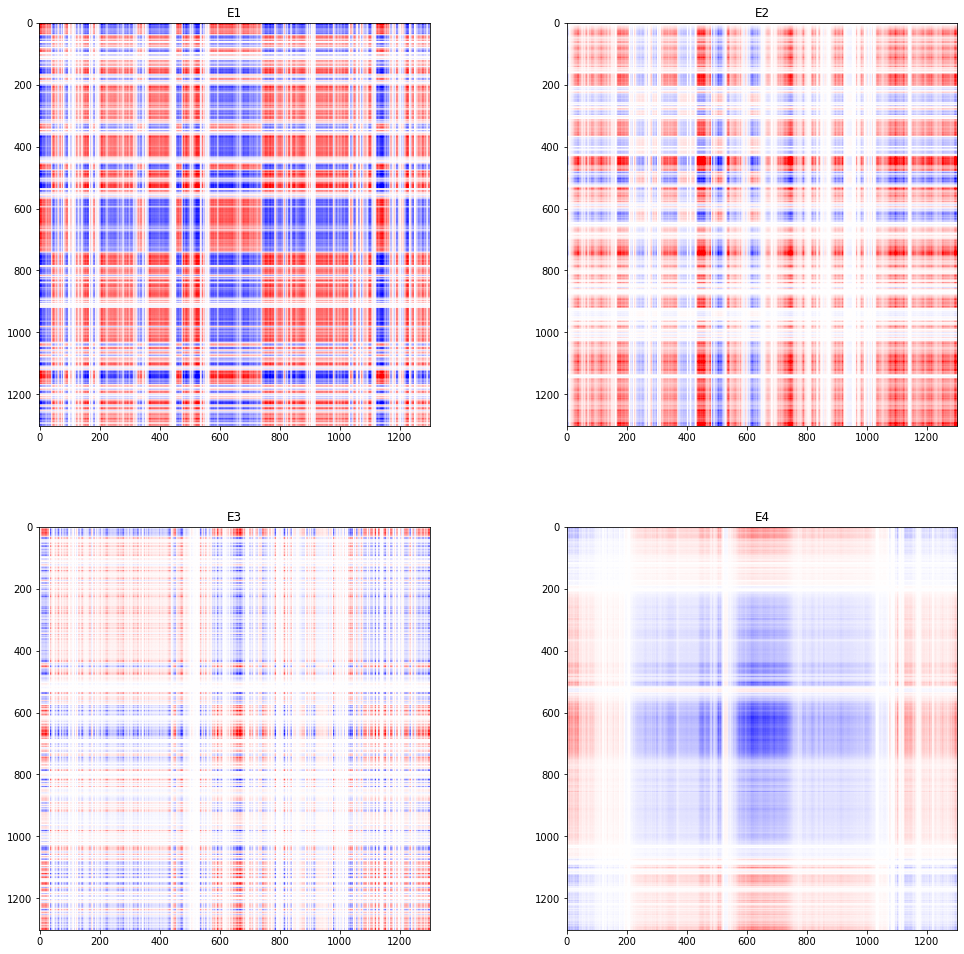

In [155]:
outers = eigendecomp.get_outer(sub, n = 10)
plt.figure(figsize= (15, 15))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title('E'+ str(i+1))
    plt.imshow(outers[i],aspect='auto',cmap='bwr'
              ,vmin = -1, vmax = 1);
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

## Summing the outerproducts

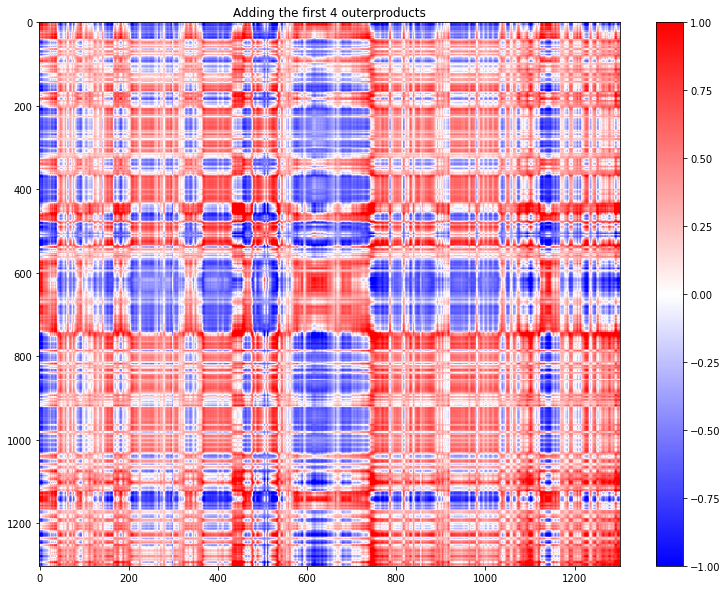

In [156]:
plt.figure(figsize = (13, 10))

plt.title('Adding the first 4 outerproducts')
plt.imshow(outers[0:2].sum(axis = 0),aspect='auto',cmap='bwr'
          ,interpolation='bilinear', vmin = -1, vmax = 1)
plt.colorbar();
    
plt.show()

## The outerproduct of E1 correlates well with the original enrichment

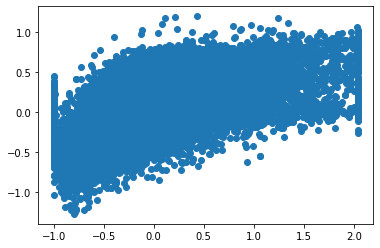

In [157]:
plt.scatter(sub.reshape(-1, 1)[::100], outers[0].reshape(-1,1)[::100])

In [158]:
eigendecomp.correlation2D(sub, outers[0])

0.6200466791902447

## Let's try other operations

In [159]:
ops = ['clip', 'log','cliplog', 'tanh', 'tanhlog']

In [160]:
enrich = [eigendecomp.apply_op(enrichment, op) for op in ops]

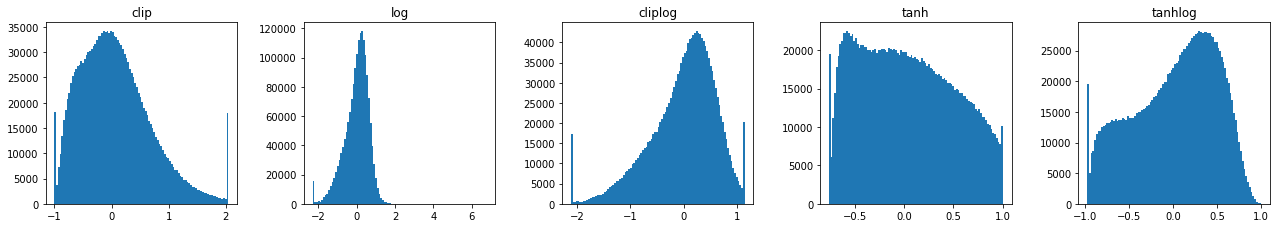

In [161]:
plt.figure(figsize= (20, 3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title(ops[i])
    plt.hist(enrich[i].reshape(-1,1), bins = 100);
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

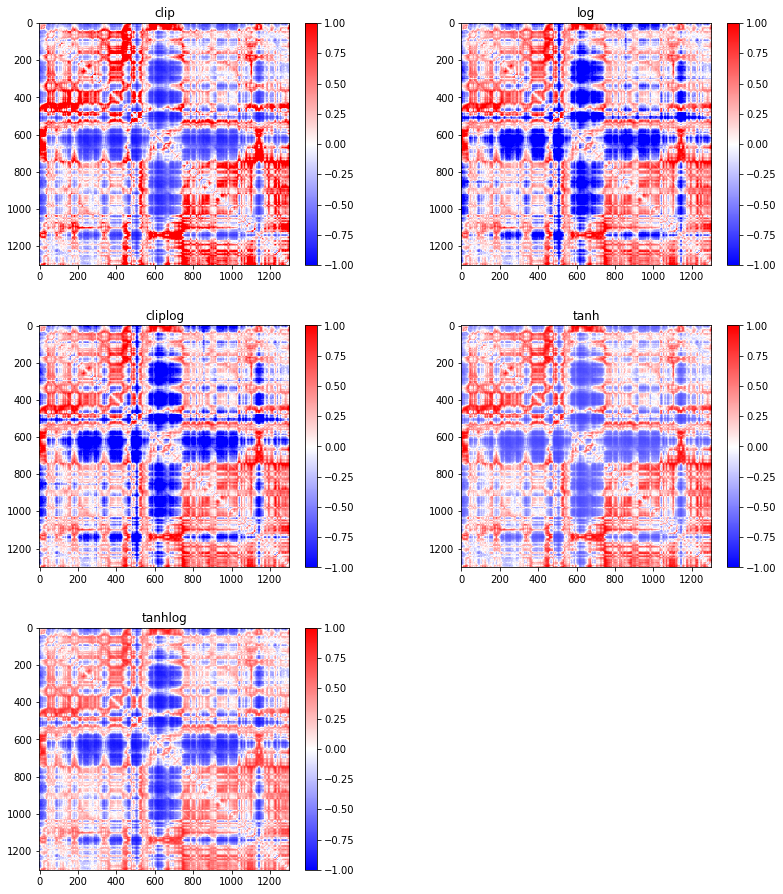

In [162]:
plt.figure(3, figsize = (12, 14))

for i in range(5):
    plt.subplot(3,2,i+1)
    plt.title(ops[i])
    plt.imshow(enrich[i]
                ,aspect='auto',cmap='bwr'
              ,interpolation='bilinear', vmin = -1, vmax = 1)
    plt.colorbar();
    
    

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

In [163]:
Z = [eigendecomp.get_eig(e) for e in enrich]

In [164]:
genes = bins[bins.chrom == ch].gene_count[mask].values

## They give similar eigenvectors

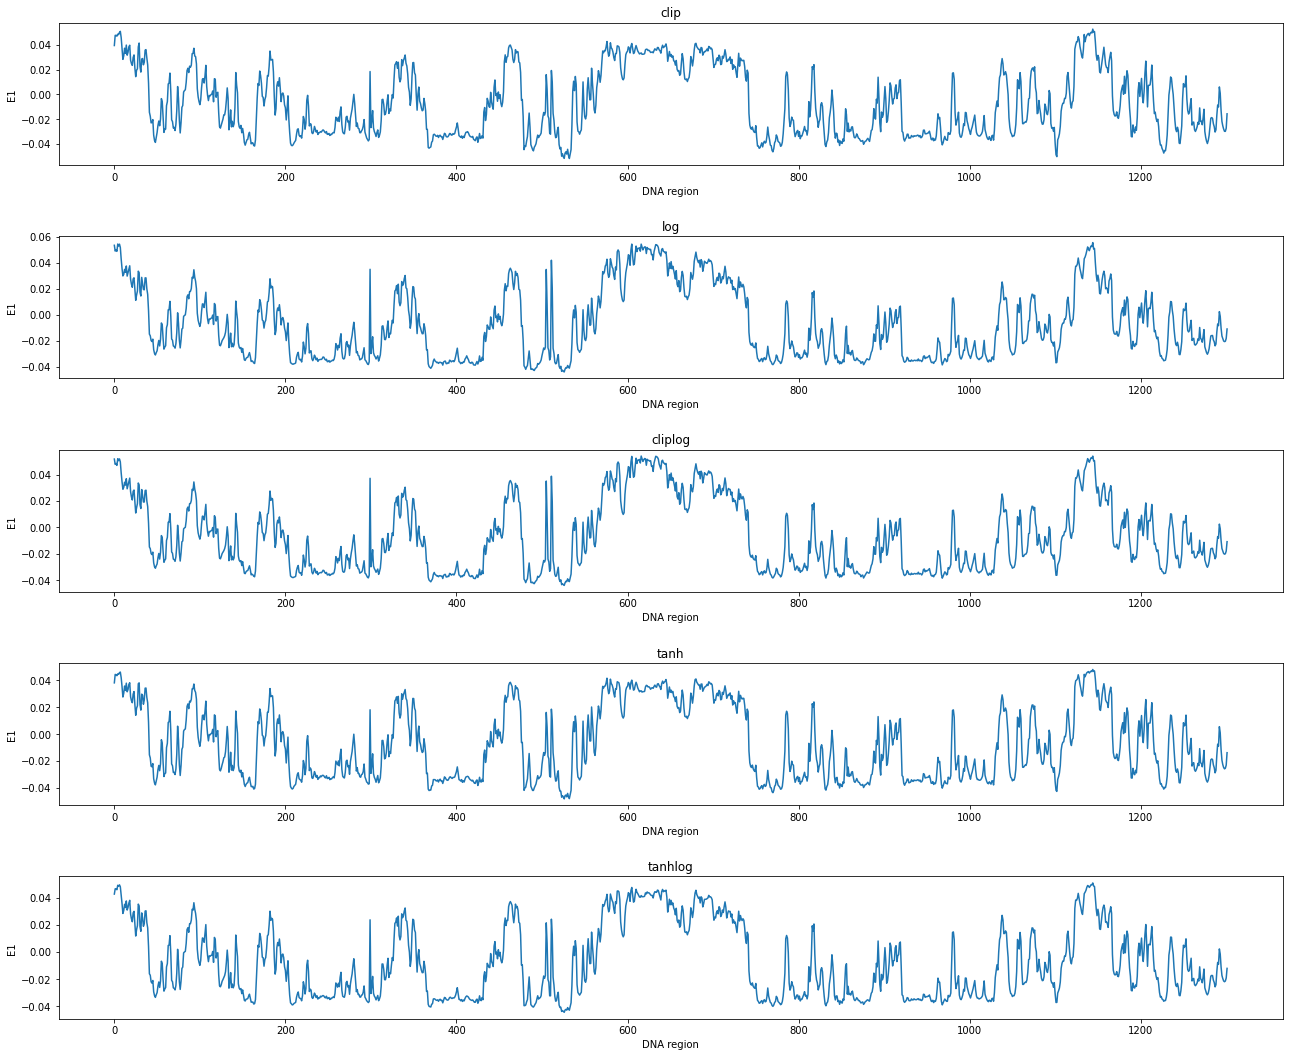

In [165]:
i = 0
plt.figure(figsize=(20, 20))
for S, E in Z:
    plt.subplot(6,1,i+1)
    plt.title(ops[i])
    v= eigendecomp.orient_vector(E[:, 0:1], genes)
    
    plt.plot(v)
    #plt.plot((genes - 0.5))
    plt.xlabel('DNA region')
    plt.ylabel('E1')
    i+= 1
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)

## Let's try a different chromosome

In [166]:
ch = 'chr19'
mat = df['cooler'].iloc[0].matrix(balance = False).fetch(ch)
mask, mask2D = preprocessing.create_mask(mat, start = 2.5, end = 97.5)
mat[~mask2D] = 0
W, B, res = preprocessing.correction(mat, maxiter = 10000, mask = mask)
genes = bins[bins.chrom == ch].gene_count[mask].values

In [167]:
Z = [eigendecomp.eigendecomp(W, mask = mask, operation=op, n =3, genetrack = genes) for op in ops]

## We get enhanced eigenvectors

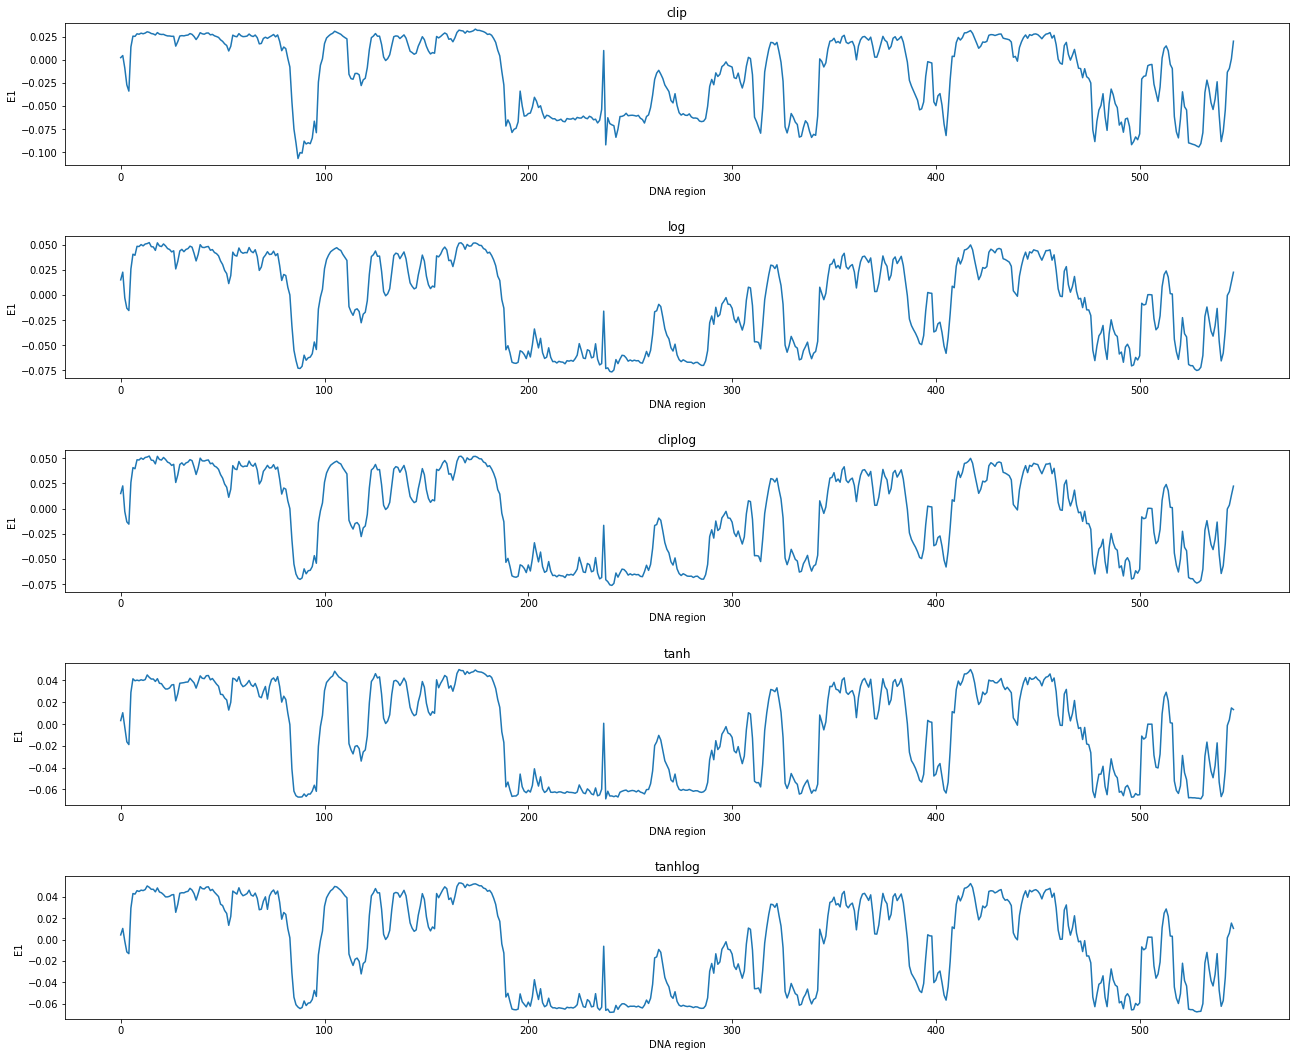

In [168]:
i = 0
plt.figure(figsize=(20, 20))
for S, E in Z:
    plt.subplot(6,1,i+1)
    plt.title(ops[i])
    plt.plot(E[:,0])
    plt.xlabel('DNA region')
    plt.ylabel('E1')
    i+= 1
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)

In [169]:
for S, E in Z:
    print('Pearson correlation:', eigendecomp.correlation1D(E[:, 0], genes))

Pearson correlation: 0.2885337530684743
Pearson correlation: 0.3557687361329769
Pearson correlation: 0.3569696356203751
Pearson correlation: 0.3288458115043925
Pearson correlation: 0.34784719982135615


## Let's analyze the entire genome

In [170]:
c = df['cooler'].iloc[0]

In [171]:
bins = c.bins()[:]
bins['gene_count'] = genecov_dict['hg19']

In [172]:
regions = bins.chrom.unique()[:-3]

## We discard X, Y and M since they have large variability between experiments

In [230]:
regions

[chr1, chr2, chr3, chr4, chr5, ..., chr18, chr19, chr20, chr21, chr22]
Length: 22
Categories (25, object): [chr1 < chr2 < chr3 < chr4 ... chr22 < chrX < chrY < chrM]

In [174]:
tracks = eigendecomp.cooler_eigendecomp(c, bins, regions, operations = ['clip', 'log','cliplog', 'tanh', 'tanhlog'], trackname = 'gene_count', n = 3)

In [175]:
tracks

chrom     start       end    weight  gene_count   E1_clip   E2_clip  \
0       chr1         0    100000       NaN     0.22742 -0.007171  0.042143   
1       chr1    100000    200000       NaN     0.42396 -0.005657  0.041664   
2       chr1    200000    300000       NaN     1.00000 -0.006490  0.045712   
3       chr1    300000    400000       NaN     0.46231       NaN       NaN   
4       chr1    400000    500000       NaN     0.07159       NaN       NaN   
...      ...       ...       ...       ...         ...       ...       ...   
28818  chr22  50900000  51000000  0.001843     0.65086 -0.053043  0.070371   
28819  chr22  51000000  51100000  0.001847     0.40762 -0.069230  0.054063   
28820  chr22  51100000  51200000  0.002423     0.74186 -0.096245  0.037962   
28821  chr22  51200000  51300000       NaN     0.40099 -0.069493  0.048140   
28822  chr22  51300000  51304566       NaN     0.00000       NaN       NaN   

        E3_clip    E1_log    E2_log    E3_log  E1_cliplog  E2_cliplog  \
0     -0.009594  0.006795 -0.088022 -0.106837    0.009986   -0.087326   
1     -0.012397  0.008801 -0.087031 -0.105676    0.011560   -0.086684   
2     -0.010055  0.009414 -0.091212 -0.107901    0.011489   -0.089520   
3           NaN       NaN       NaN       NaN         NaN         NaN   
4           NaN       NaN       NaN       NaN         NaN         NaN   
...         ...       ...       ...       ...         ...         ...   
28818  0.080572  0.057051  0.044749  0.101073    0.058385    0.048054   
28819  0.095038  0.068796  0.021322  0.108589    0.069312    0.026265   
28820  0.098224  0.086949 -0.007810  0.107059    0.086057    0.001538   
28821  0.081499  0.060528  0.018372  0.044210    0.057297    0.022175   
28822       NaN       NaN       NaN       NaN         NaN         NaN   

       E3_cliplog   E1_tanh   E2_tanh   E3_tanh  E1_tanhlog  E2_tanhlog  \
0       -0.105729 -0.000932 -0.049705 -0.002799    0.001024   -0.062647   
1       -0.104810  0.000003 -0.049418 -0.004627    0.002111   -0.062292   
2       -0.107189 -0.000266 -0.052002 -0.002672    0.001900   -0.065035   
3             NaN       NaN       NaN       NaN         NaN         NaN   
4             NaN       NaN       NaN       NaN         NaN         NaN   
...           ...       ...       ...       ...         ...         ...   
28818   -0.090654  0.057857  0.061135  0.065299    0.058677    0.053448   
28819   -0.090785  0.070820  0.040859  0.049328    0.069925    0.032497   
28820   -0.072693  0.084472  0.014003  0.026598    0.083051    0.007678   
28821   -0.035669  0.057527  0.022204  0.010402    0.056953    0.019376   
28822         NaN       NaN       NaN       NaN         NaN         NaN   

       E3_tanhlog  
0       -0.090092  
1       -0.088788  
2       -0.090863  
3             NaN  
4             NaN  
...           ...  
28818   -0.076626  
28819   -0.061877  
28820   -0.031230  
28821   -0.014794  
28822         NaN  

[28823 rows x 20 columns]

In [176]:
mask = ~tracks['E1_clip'].isna()

In [177]:
corr=tracks[mask].iloc[:, [4, 5, 8, 11, 14, 17]].corr('pearson')

In [178]:
corr

gene_count   E1_clip    E1_log  E1_cliplog   E1_tanh  E1_tanhlog
gene_count    1.000000  0.301506  0.313140    0.340945  0.355385    0.358129
E1_clip       0.301506  1.000000  0.823286    0.725437  0.799602    0.789390
E1_log        0.313140  0.823286  1.000000    0.905705  0.827246    0.839968
E1_cliplog    0.340945  0.725437  0.905705    1.000000  0.920997    0.933902
E1_tanh       0.355385  0.799602  0.827246    0.920997  1.000000    0.994490
E1_tanhlog    0.358129  0.789390  0.839968    0.933902  0.994490    1.000000

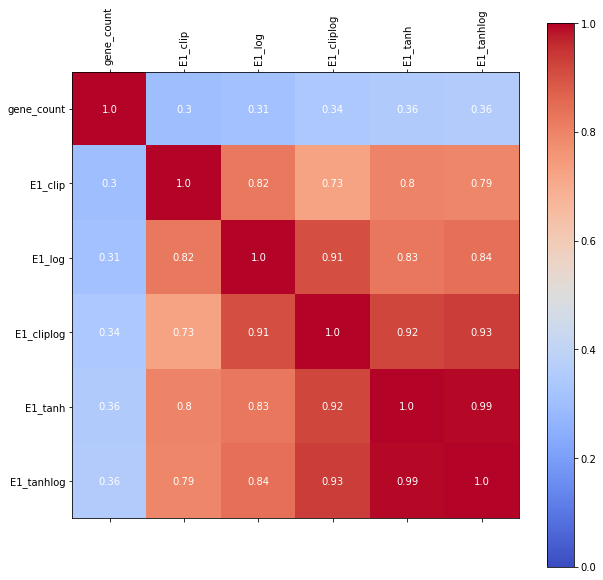

In [180]:
fig = plt.figure(figsize  =(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=0, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
for i in range(len(corr)):
    for j in range(len(corr)):
        text = ax.text(j, i, np.round(corr.iloc[i, j], 2),
                       ha="center", va="center", color="w")
plt.show()